# Test Pose Estimation using Faster-RCNN + HRNet

In [1]:
import os
import sys
import json
import collections
from tqdm import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.nn import DataParallel
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

sys.path.append("..")

from data import StyledCoco, hrnet_coco
import models
from models.utils.hrnet_config import _C as cfg
from models.utils.hrnet_config import update_config
from models.utils.config import opt
from CONFIG import CONFIG
import CONSTANTS
import data
from data.custom_transforms import Normalize
import lib.arguments as arguments
import lib.utils as utils
import lib.loss as loss
import lib.inference as inference
import lib.metrics as metrics
import lib.pose_parsing as pose_parsing 
import lib.visualizations as visualizations


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
exp_name = os.path.join("notebook_tests", "hrnet_notebook")
test_exp = os.path.join(CONFIG["paths"]["experiments_path"], exp_name)
data_path = CONFIG["paths"]["data_path"]
original_imgs_path = os.path.join(data_path, "original_images", "val2017")
labels_path = os.path.join(data_path, "annotations")
labels_file = os.path.join(labels_path, "person_keypoints_validation.json")
preds_file = os.path.join(test_exp, CONFIG["paths"]["submission"])

In [4]:
COCO_KEYPOINT_INDEXES = {
    0: 'nose',
    1: 'left_eye',
    2: 'right_eye',
    3: 'left_ear',
    4: 'right_ear',
    5: 'left_shoulder',
    6: 'right_shoulder',
    7: 'left_elbow',
    8: 'right_elbow',
    9: 'left_wrist',
    10: 'right_wrist',
    11: 'left_hip',
    12: 'right_hip',
    13: 'left_knee',
    14: 'right_knee',
    15: 'left_ankle',
    16: 'right_ankle'
}

# Dataset

In [5]:
image_size = 600
exp_data = utils.load_experiment_parameters(test_exp)
exp_data["training"]["batch_size"] = 4
exp_data["dataset"]["dataset_name"] = "coco"
exp_data["dataset"]["image_size"] = image_size
exp_data["model"]["model_name"] = "HRNet"

In [6]:
cfg = update_config()

In [7]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
# normalize = Normalize(
#     mean=[128, 128, 128], std=[256, 256, 256]
# )

In [8]:
valid_dataset = data.HRNetCoco(root=data_path, img_path=original_imgs_path,
                               labels_path=labels_file, is_train=False,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   normalize,
                               ]))

loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


In [9]:
valid_loader = torch.utils.data.DataLoader(
                    valid_dataset,
                    batch_size=1,
                    shuffle=False,
                    num_workers=4,
                    pin_memory=True
                )

In [10]:
img, target, target_weight, meta = next(iter(valid_loader))

In [11]:
print(meta["joints"])
print(meta["center"])
print(meta["scale"])
print(meta.keys())

tensor([[[ 88.6963,  43.4280,   0.0000],
         [ 89.4367,  40.4665,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [ 96.1000,  46.3895,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [ 79.0715,  68.6004,   0.0000],
         [119.0513,  72.3023,   0.0000],
         [ 61.3028,  93.7729,   0.0000],
         [130.1568, 101.9169,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000],
         [ 78.3312, 132.2719,   0.0000],
         [107.2054, 133.0123,   0.0000],
         [ 72.4082, 176.6939,   0.0000],
         [107.2054, 175.9535,   0.0000],
         [ 65.7450, 220.3755,   0.0000],
         [112.3880, 221.1158,   0.0000]]], dtype=torch.float64)
tensor([[442.8650, 208.2300]])
tensor([[1.2967, 1.7289]])
dict_keys(['image', 'original_image', 'filename', 'imgnum', 'joints', 'joints_vis', 'center', 'scale', 'rotation', 'score'])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


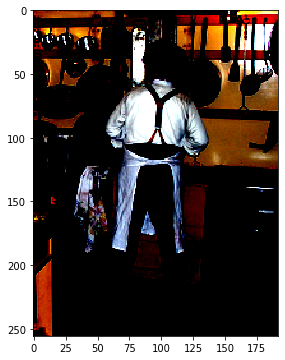

In [12]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)
ax.imshow(img[0,:].numpy().transpose(1,2,0))
plt.show()

In [13]:
print(img[0,0,:5,:5])

tensor([[0.6392, 0.6049, 0.6221, 0.6049, 0.6392],
        [0.5193, 0.5022, 0.4679, 0.5536, 0.5707],
        [0.5364, 0.5707, 0.3823, 0.5193, 0.5536],
        [0.6049, 0.6221, 0.5536, 0.5364, 0.5707],
        [0.6392, 0.7077, 0.6392, 0.6049, 0.6049]])


# Model

In [14]:
# HRNet Model
hrnet = models.PoseHighResolutionNet(is_train=False)
pretrained_path = os.path.join(CONFIG["paths"]["pretrained_path"], "HRnet", "pose_hrnet_w32_256x192.pth")
hrnet.load_state_dict(torch.load(pretrained_path))

<All keys matched successfully>

# Inference

In [15]:
device = "cpu"
output = inference.forward_pass(model=hrnet, img=img,
                                model_name="HRNet",
                                device=device)

In [16]:
loss_function = loss.PersonMSELoss()
cur_loss = loss_function(output, target, target_weight).item()
_, avg_acc, cnt, pred = metrics.accuracy(output.detach().numpy(),
                                         target.numpy())
print(f"Loss: {round(cur_loss, 6)}")
print(f"Accuracy: {round(avg_acc,6)}")

Loss: 0.000224
Accuracy: 0.923077


In [23]:
centers = meta["center"].numpy()
scales = meta["scale"].numpy()
score = meta["score"].numpy()

print(f"Centers: {centers}")
print(f"Scales: {scales}")

Centers: [[442.865 208.23 ]]
Scales: [[1.2966563 1.728875 ]]


In [27]:
keypoints, max_vals, coords = pose_parsing.get_final_preds_hrnet(output.detach().numpy(), centers, scales)
print("Keypoints:")
print(keypoints[0,:5,:])
print("Max Vals:")
print(max_vals[0,:5,:])

Keypoints:
[[430.70883  93.4219 ]
 [436.11157  90.72053]
 [433.41022  90.72053]
 [441.5143   96.12326]
 [465.8266  101.52599]]
Max Vals:
[[0.8558458 ]
 [0.85875034]
 [0.70309836]
 [0.86613846]
 [0.6833181 ]]
